In [5]:
import pandas as pd
import re
import os
import sys

In [9]:
#creating train and test dataframes of images
file_path=pd.DataFrame({'image_path':os.listdir('../raw/train')})
file_path_test=pd.DataFrame({'image_path':os.listdir('../raw/test')})

In [10]:
#getting subject and image name from train data
subject=file_path.image_path.apply(lambda x:re.split('_',x)[0])
img_name=file_path_test.image_path.apply(lambda x:x.split('.')[0])
grb=file_path.image_path.apply(lambda x:re.search('_[0-9]+',x).group())
image_name=grb.apply(lambda x:re.split('_',x)[1])

In [11]:
#adding two columns image name and subject name
file_path['image_name']=image_name
file_path['subject_name']=subject
file_path_test['image_name']=img_name

In [12]:
#adding file location to file name.
file_path.image_path=file_path.image_path.apply(lambda x:'train/'+x)
file_path_test.image_path=file_path_test.image_path.apply(lambda x:'test/'+x)


In [43]:
#separating mask images from train images
msk=[i for i in range(len(file_path.image_path)) if 'mask' in file_path.image_path[i]]
img=[i for i in range(len(file_path.image_path)) if 'mask' not in file_path.image_path[i]]
msk=file_path.loc[msk]
img=file_path.loc[img]

In [44]:
#aligning both to be concatenated later
msk=msk.sort_values(by=['image_name','subject_name'])
img=img.sort_values(by=['image_name','subject_name'])

In [45]:
#adding mask image path to the df
img['mask_path']=msk.image_path.values

In [46]:
img.head()

,image_path,image_name,subject_name,mask_path
2398,train/1_1.tif,1,1,train/1_1_mask.tif
0,train/10_1.tif,1,10,train/10_1_mask.tif
240,train/11_1.tif,1,11,train/11_1_mask.tif
480,train/12_1.tif,1,12,train/12_1_mask.tif
720,train/13_1.tif,1,13,train/13_1_mask.tif


In [47]:
img = img.reset_index(drop=True)

In [48]:
img.image_path.iloc[[0]]

0    train/1_1.tif
Name: image_path, dtype: object

In [49]:
from PIL import Image
im = Image.open('../raw/train/1_1.tif')
im.show()

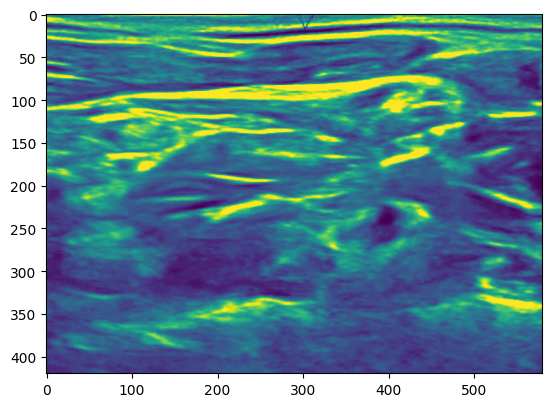

In [50]:
import matplotlib.pyplot as plt
img_plt = plt.imread('../raw/train/1_1.tif')
plt.imshow(img_plt)
plt.show()

In [62]:
#creating an array that will store all images in 64*64 resized format
import numpy as np
import cv2
from skimage.transform import resize
X1 = np.zeros((len(img), 64, 64), dtype=np.float32)
for i in range(len(img)):
  img1=cv2.imread("raw..//"+str(img.image_path[i]),cv2.IMREAD_GRAYSCALE)
  img1=resize(img1, (64,64), mode = 'constant', preserve_range = True)
  X1[i]=img1

In [65]:
#finding similarity between resized images and storing it in a dictionary
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim

sim=dict()
for i in tqdm(range(len(X1))):
  for j in range(len(X1)):
      if i!=j:
        if tuple(sorted((i,j))) not in sim.keys():
          simil=ssim(X1[i],X1[j])
          if abs(simil)>0.99:
            sim[tuple(sorted((i,j)))]=simil

100%|██████████| 5635/5635 [3:53:25<00:00,  2.49s/it]     


In [68]:
#storing conflicting images' keys in a list if their similarity is >0.99 in their resized form
conf=[]
for i in tqdm(sim.keys()):
  if sim[i]>0.99:
    msk1=cv2.imread("../raw/"+str(img.mask_path[i[0]]),cv2.IMREAD_GRAYSCALE)
    msk2=cv2.imread("../raw/"+str(img.mask_path[i[1]]),cv2.IMREAD_GRAYSCALE)
    if msk1.any()!=msk2.any():
      conf.append(i)

100%|██████████| 1235/1235 [00:03<00:00, 339.10it/s]


In [69]:
# total amount of images with conflicting masks:
len(conf)

308

In [78]:
# show first image with conflicting masks 
a_img = cv2.imread("../raw/"+str(img.image_path[conf[0][0]]),cv2.IMREAD_GRAYSCALE)
a_mask1 = cv2.imread("../raw/"+str(img.mask_path[conf[0][0]]),cv2.IMREAD_GRAYSCALE)
a_mask2 = cv2.imread("../raw/"+str(img.mask_path[conf[0][1]]),cv2.IMREAD_GRAYSCALE)
conc = np.concatenate((a_mask1, a_img, a_mask2), axis=1)
cv2.imshow('Original image and two conflicting masks', conc)
cv2.waitKey(0)
cv2.destroyAllWindows()

KeyError: 114

In [74]:
#out of conflicting image pair dropping the image that doesn't contains a mask
indices=[img.iloc[i[1]].name if cv2.imread("../raw/"+str(img.mask_path[i[0]]), cv2.IMREAD_GRAYSCALE).any()==True else img.iloc[i[0]].name for i in conf]
indices=list(set(indices))
img.drop(indices,axis=0,inplace=True)

In [80]:
img.head(5)
img.to_csv("df.csv")